In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 4 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.


100%|██████████| 9912422/9912422 [00:00<00:00, 18656566.75it/s]


Extracting input/data\MNIST\raw\train-images-idx3-ubyte.gz to input/data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting input/data\MNIST\raw\train-labels-idx1-ubyte.gz to input/data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5554464.40it/s]


Extracting input/data\MNIST\raw\t10k-images-idx3-ubyte.gz to input/data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting input/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to input/data\MNIST\raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1) * 0.9  # Apply Label Smoothing
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1) * 0.1 # Apply Label Smoothing
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:15,  7.39it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


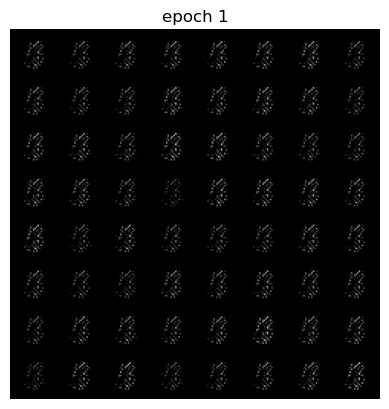

Epoch 1 of 200
Generator loss: 1.42358176, Discriminator loss: 0.94183281


118it [00:15,  7.59it/s]                         


Epoch 2 of 200
Generator loss: 1.46808419, Discriminator loss: 1.21847113


118it [00:15,  7.61it/s]                         


Epoch 3 of 200
Generator loss: 1.37628307, Discriminator loss: 0.98446442


118it [00:14,  7.97it/s]                         


Epoch 4 of 200
Generator loss: 1.37852959, Discriminator loss: 1.13504965


118it [00:14,  7.96it/s]                         


Epoch 5 of 200
Generator loss: 1.12927295, Discriminator loss: 1.16600950


118it [00:14,  8.01it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


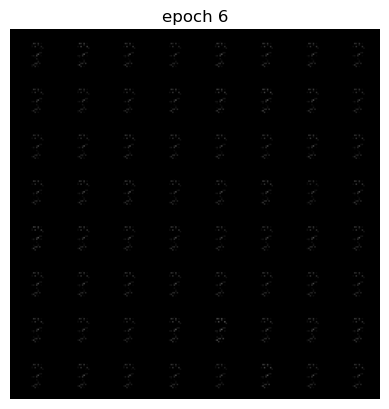

Epoch 6 of 200
Generator loss: 1.46156391, Discriminator loss: 1.06210309


118it [00:14,  7.99it/s]                         


Epoch 7 of 200
Generator loss: 1.53361537, Discriminator loss: 0.95687516


118it [00:14,  8.00it/s]                         


Epoch 8 of 200
Generator loss: 1.76562349, Discriminator loss: 1.04059771


118it [00:14,  7.89it/s]                         


Epoch 9 of 200
Generator loss: 1.51233092, Discriminator loss: 1.01620139


118it [00:15,  7.66it/s]                         


Epoch 10 of 200
Generator loss: 2.05554354, Discriminator loss: 0.84943651


118it [00:15,  7.67it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


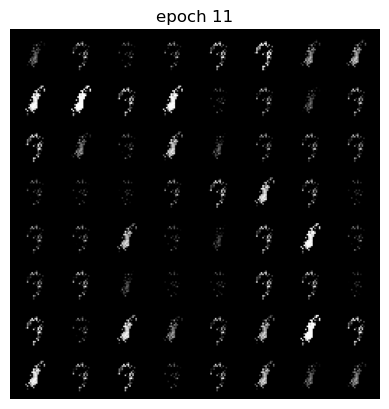

Epoch 11 of 200
Generator loss: 1.99490836, Discriminator loss: 0.86468196


118it [00:15,  7.69it/s]                         


Epoch 12 of 200
Generator loss: 1.86070148, Discriminator loss: 0.94365496


118it [00:15,  7.81it/s]                         


Epoch 13 of 200
Generator loss: 1.76159731, Discriminator loss: 0.93659764


118it [00:15,  7.61it/s]                         


Epoch 14 of 200
Generator loss: 2.02326643, Discriminator loss: 0.79435056


118it [00:15,  7.79it/s]                         


Epoch 15 of 200
Generator loss: 2.09894664, Discriminator loss: 0.80887951


118it [00:15,  7.55it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


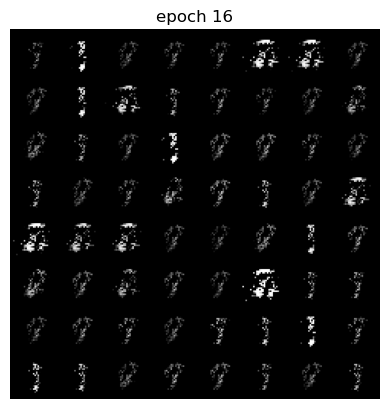

Epoch 16 of 200
Generator loss: 2.18996836, Discriminator loss: 0.78551080


118it [00:15,  7.78it/s]                         


Epoch 17 of 200
Generator loss: 2.38205652, Discriminator loss: 0.78668581


118it [00:15,  7.79it/s]                         


Epoch 18 of 200
Generator loss: 2.49344163, Discriminator loss: 0.77818937


118it [00:15,  7.63it/s]                         


Epoch 19 of 200
Generator loss: 2.46766011, Discriminator loss: 0.77651495


118it [00:14,  7.96it/s]                         


Epoch 20 of 200
Generator loss: 2.54546989, Discriminator loss: 0.75114307


118it [00:14,  7.98it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


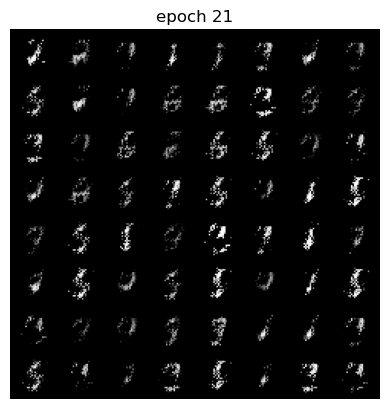

Epoch 21 of 200
Generator loss: 2.27902597, Discriminator loss: 0.83347652


118it [00:14,  8.01it/s]                         


Epoch 22 of 200
Generator loss: 2.28779834, Discriminator loss: 0.80026619


118it [00:14,  7.98it/s]                         


Epoch 23 of 200
Generator loss: 2.34402040, Discriminator loss: 0.79349353


118it [00:14,  7.97it/s]                         


Epoch 24 of 200
Generator loss: 2.71890917, Discriminator loss: 0.70028394


118it [00:14,  8.03it/s]                         


Epoch 25 of 200
Generator loss: 2.62026203, Discriminator loss: 0.73653211


118it [00:14,  7.91it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


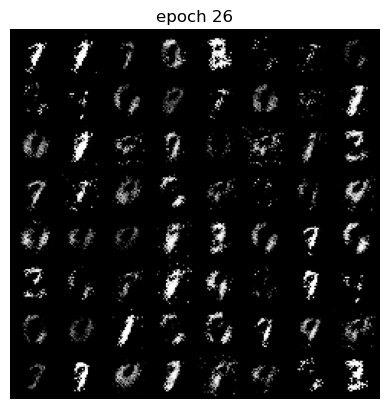

Epoch 26 of 200
Generator loss: 2.91995418, Discriminator loss: 0.66092241


118it [00:14,  8.05it/s]                         


Epoch 27 of 200
Generator loss: 2.86142866, Discriminator loss: 0.71455246


118it [00:14,  8.06it/s]                         


Epoch 28 of 200
Generator loss: 2.81095022, Discriminator loss: 0.68778720


118it [00:15,  7.84it/s]                         


Epoch 29 of 200
Generator loss: 2.95194244, Discriminator loss: 0.70124196


118it [00:15,  7.63it/s]                         


Epoch 30 of 200
Generator loss: 2.90806953, Discriminator loss: 0.69564970


118it [00:14,  7.97it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


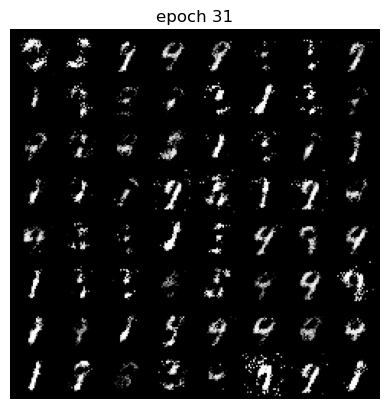

Epoch 31 of 200
Generator loss: 2.68895549, Discriminator loss: 0.75529346


118it [00:14,  7.98it/s]                         


Epoch 32 of 200
Generator loss: 2.68703290, Discriminator loss: 0.73687418


118it [00:14,  8.02it/s]                         


Epoch 33 of 200
Generator loss: 2.46781155, Discriminator loss: 0.78473688


118it [00:14,  8.01it/s]                         


Epoch 34 of 200
Generator loss: 2.38636239, Discriminator loss: 0.78273867


118it [00:14,  7.98it/s]                         


Epoch 35 of 200
Generator loss: 2.24422313, Discriminator loss: 0.81307820


118it [00:14,  8.01it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


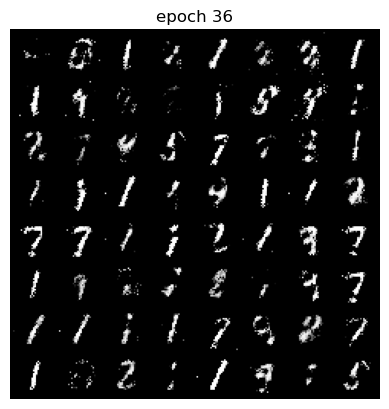

Epoch 36 of 200
Generator loss: 2.35346368, Discriminator loss: 0.78321429


118it [00:14,  8.00it/s]                         


Epoch 37 of 200
Generator loss: 2.26820756, Discriminator loss: 0.80431923


118it [00:19,  6.15it/s]                         


Epoch 38 of 200
Generator loss: 2.23300508, Discriminator loss: 0.83604503


118it [00:26,  4.48it/s]                         


Epoch 39 of 200
Generator loss: 2.27636765, Discriminator loss: 0.81487486


118it [00:26,  4.39it/s]                         


Epoch 40 of 200
Generator loss: 2.35354841, Discriminator loss: 0.80946451


118it [00:18,  6.31it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


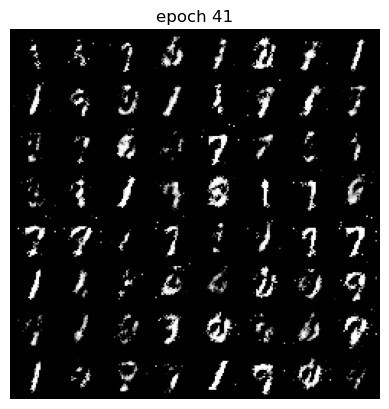

Epoch 41 of 200
Generator loss: 2.24337298, Discriminator loss: 0.82628555


118it [00:14,  7.87it/s]                         


Epoch 42 of 200
Generator loss: 2.21928843, Discriminator loss: 0.82979846


118it [00:14,  8.03it/s]                         


Epoch 43 of 200
Generator loss: 2.22963665, Discriminator loss: 0.82772305


118it [00:14,  7.96it/s]                         


Epoch 44 of 200
Generator loss: 2.15662344, Discriminator loss: 0.85066467


118it [00:14,  8.04it/s]                         


Epoch 45 of 200
Generator loss: 2.12404093, Discriminator loss: 0.84574084


118it [00:14,  7.99it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


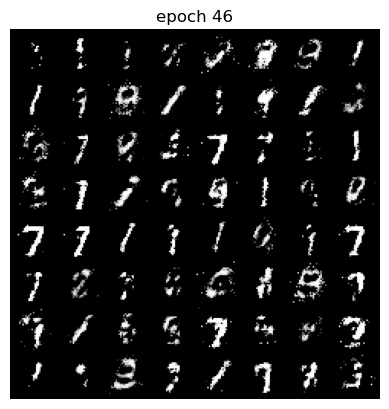

Epoch 46 of 200
Generator loss: 2.03789349, Discriminator loss: 0.87607523


118it [00:15,  7.74it/s]                         


Epoch 47 of 200
Generator loss: 2.10868308, Discriminator loss: 0.85186363


118it [00:15,  7.77it/s]                         


Epoch 48 of 200
Generator loss: 1.94940321, Discriminator loss: 0.90761230


118it [00:14,  7.97it/s]                         


Epoch 49 of 200
Generator loss: 1.98160348, Discriminator loss: 0.89614154


118it [00:14,  7.94it/s]                         


Epoch 50 of 200
Generator loss: 1.87060622, Discriminator loss: 0.91575798


118it [00:15,  7.86it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


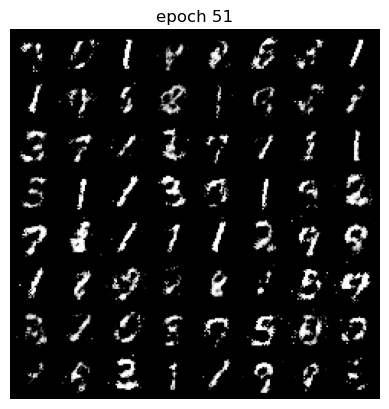

Epoch 51 of 200
Generator loss: 1.93951720, Discriminator loss: 0.89829804


118it [00:15,  7.67it/s]                         


Epoch 52 of 200
Generator loss: 1.86579610, Discriminator loss: 0.92377168


118it [00:14,  8.02it/s]                         


Epoch 53 of 200
Generator loss: 1.82955970, Discriminator loss: 0.93531098


118it [00:14,  8.01it/s]                         


Epoch 54 of 200
Generator loss: 1.82903078, Discriminator loss: 0.93209653


118it [00:15,  7.75it/s]                         


Epoch 55 of 200
Generator loss: 1.80265460, Discriminator loss: 0.94283847


118it [00:15,  7.74it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


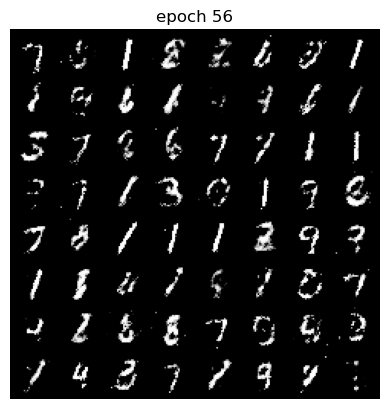

Epoch 56 of 200
Generator loss: 1.73689186, Discriminator loss: 0.96947444


118it [00:14,  8.03it/s]                         


Epoch 57 of 200
Generator loss: 1.70513302, Discriminator loss: 0.97434228


118it [00:14,  8.04it/s]                         


Epoch 58 of 200
Generator loss: 1.65915002, Discriminator loss: 1.00182801


118it [00:14,  8.01it/s]                         


Epoch 59 of 200
Generator loss: 1.65561464, Discriminator loss: 0.98600406


118it [00:14,  7.92it/s]                         


Epoch 60 of 200
Generator loss: 1.69230106, Discriminator loss: 0.98501193


118it [00:14,  8.00it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


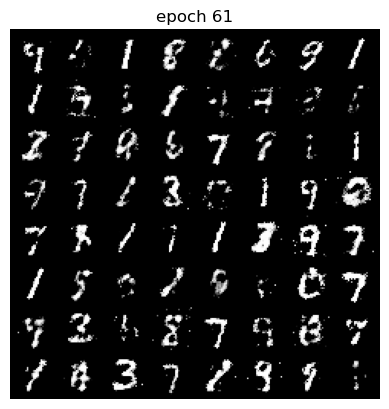

Epoch 61 of 200
Generator loss: 1.67941319, Discriminator loss: 0.99354342


118it [00:25,  4.59it/s]                         


Epoch 62 of 200
Generator loss: 1.59185235, Discriminator loss: 1.02009902


118it [00:26,  4.49it/s]                         


Epoch 63 of 200
Generator loss: 1.63005552, Discriminator loss: 1.00908847


118it [00:26,  4.51it/s]                         


Epoch 64 of 200
Generator loss: 1.63702425, Discriminator loss: 0.99913503


118it [00:26,  4.52it/s]                         


Epoch 65 of 200
Generator loss: 1.59333014, Discriminator loss: 1.01933385


118it [00:26,  4.51it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


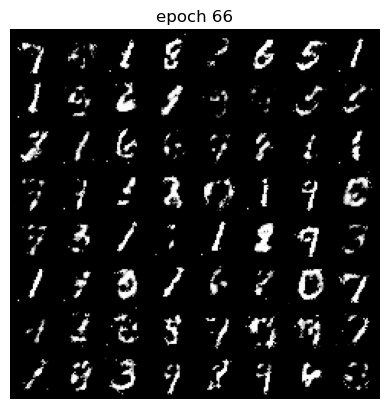

Epoch 66 of 200
Generator loss: 1.59039359, Discriminator loss: 1.01768529


118it [00:26,  4.52it/s]                         


Epoch 67 of 200
Generator loss: 1.59734201, Discriminator loss: 1.02114105


118it [00:26,  4.48it/s]                         


Epoch 68 of 200
Generator loss: 1.58788772, Discriminator loss: 1.01750205


118it [00:26,  4.51it/s]                         


Epoch 69 of 200
Generator loss: 1.60525977, Discriminator loss: 1.01048599


118it [00:26,  4.51it/s]                         


Epoch 70 of 200
Generator loss: 1.57623728, Discriminator loss: 1.02116867


118it [00:26,  4.48it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


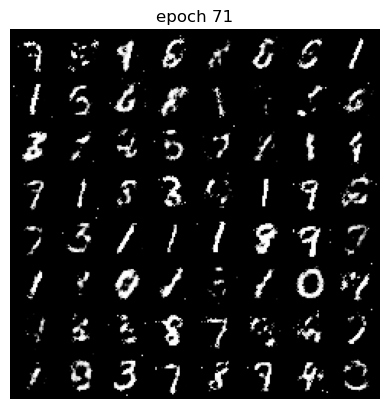

Epoch 71 of 200
Generator loss: 1.56807092, Discriminator loss: 1.01863940


118it [00:25,  4.54it/s]                         


Epoch 72 of 200
Generator loss: 1.53491302, Discriminator loss: 1.04443557


118it [00:25,  4.56it/s]                         


Epoch 73 of 200
Generator loss: 1.54229335, Discriminator loss: 1.03883217


118it [00:26,  4.53it/s]                         


Epoch 74 of 200
Generator loss: 1.58859864, Discriminator loss: 1.02909285


118it [00:25,  4.54it/s]                         


Epoch 75 of 200
Generator loss: 1.54390977, Discriminator loss: 1.03400547


118it [00:26,  4.43it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


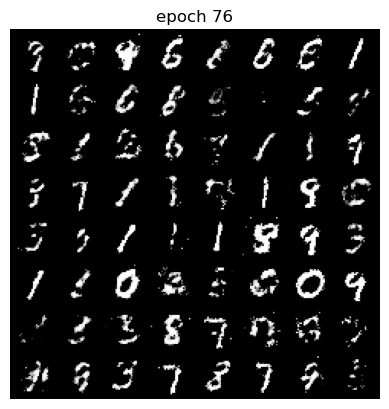

Epoch 76 of 200
Generator loss: 1.54946264, Discriminator loss: 1.04174099


118it [00:26,  4.41it/s]                         


Epoch 77 of 200
Generator loss: 1.53738699, Discriminator loss: 1.04117148


118it [00:27,  4.37it/s]                         


Epoch 78 of 200
Generator loss: 1.49306285, Discriminator loss: 1.04274688


118it [00:26,  4.43it/s]                         


Epoch 79 of 200
Generator loss: 1.50885151, Discriminator loss: 1.04617819


118it [00:26,  4.43it/s]                         


Epoch 80 of 200
Generator loss: 1.50261733, Discriminator loss: 1.04877111


118it [00:26,  4.45it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


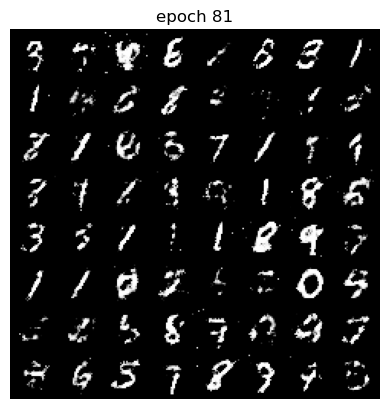

Epoch 81 of 200
Generator loss: 1.52247835, Discriminator loss: 1.03919137


118it [00:26,  4.45it/s]                         


Epoch 82 of 200
Generator loss: 1.46618107, Discriminator loss: 1.06062592


118it [00:26,  4.44it/s]                         


Epoch 83 of 200
Generator loss: 1.46985689, Discriminator loss: 1.06298766


118it [00:26,  4.42it/s]                         


Epoch 84 of 200
Generator loss: 1.44324313, Discriminator loss: 1.07091181


118it [00:26,  4.44it/s]                         


Epoch 85 of 200
Generator loss: 1.45827024, Discriminator loss: 1.06832017


118it [00:26,  4.41it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


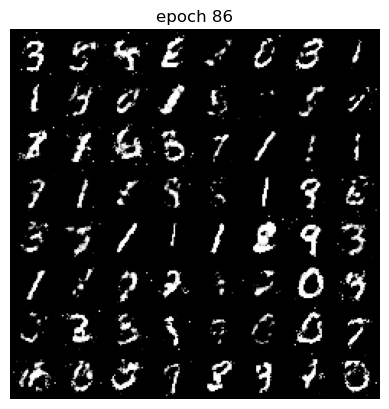

Epoch 86 of 200
Generator loss: 1.43260698, Discriminator loss: 1.07868273


118it [00:26,  4.50it/s]                         


Epoch 87 of 200
Generator loss: 1.46042506, Discriminator loss: 1.06905758


118it [00:26,  4.46it/s]                         


Epoch 88 of 200
Generator loss: 1.43588008, Discriminator loss: 1.06777728


118it [00:26,  4.46it/s]                         


Epoch 89 of 200
Generator loss: 1.43113309, Discriminator loss: 1.08300358


118it [00:22,  5.26it/s]                         


Epoch 90 of 200
Generator loss: 1.39480151, Discriminator loss: 1.09039966


118it [00:16,  7.32it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


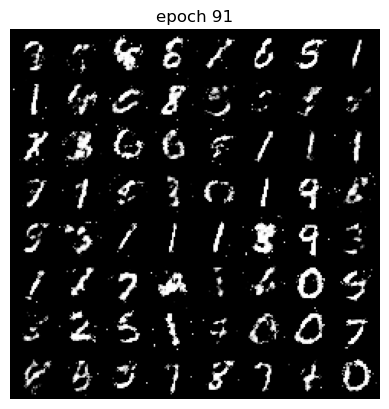

Epoch 91 of 200
Generator loss: 1.35397666, Discriminator loss: 1.10088521


118it [00:15,  7.51it/s]                         


Epoch 92 of 200
Generator loss: 1.37583517, Discriminator loss: 1.09369893


118it [00:15,  7.68it/s]                         


Epoch 93 of 200
Generator loss: 1.36461289, Discriminator loss: 1.09436438


118it [00:15,  7.41it/s]                         


Epoch 94 of 200
Generator loss: 1.37543219, Discriminator loss: 1.10159895


118it [00:16,  7.17it/s]                         


Epoch 95 of 200
Generator loss: 1.39040542, Discriminator loss: 1.09401930


118it [00:16,  7.21it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


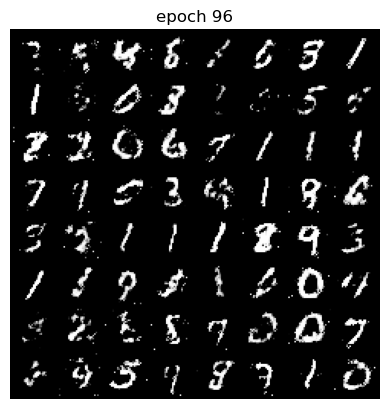

Epoch 96 of 200
Generator loss: 1.36444084, Discriminator loss: 1.09420482


118it [00:16,  7.34it/s]                         


Epoch 97 of 200
Generator loss: 1.35903355, Discriminator loss: 1.10920008


118it [00:16,  7.12it/s]                         


Epoch 98 of 200
Generator loss: 1.37635759, Discriminator loss: 1.09146020


118it [00:18,  6.30it/s]                         


Epoch 99 of 200
Generator loss: 1.31780656, Discriminator loss: 1.12094526


118it [00:15,  7.73it/s]                         


Epoch 100 of 200
Generator loss: 1.34082706, Discriminator loss: 1.11324213


118it [00:15,  7.75it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


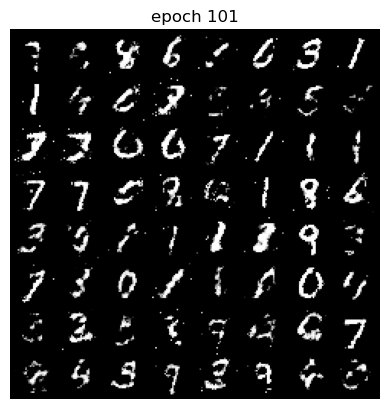

Epoch 101 of 200
Generator loss: 1.30816326, Discriminator loss: 1.11992969


118it [00:15,  7.68it/s]                         


Epoch 102 of 200
Generator loss: 1.32953775, Discriminator loss: 1.11879081


118it [00:15,  7.78it/s]                         


Epoch 103 of 200
Generator loss: 1.32159534, Discriminator loss: 1.11935429


118it [00:15,  7.59it/s]                         


Epoch 104 of 200
Generator loss: 1.33332480, Discriminator loss: 1.11760526


118it [00:15,  7.75it/s]                         


Epoch 105 of 200
Generator loss: 1.32226339, Discriminator loss: 1.11674346


118it [00:15,  7.79it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


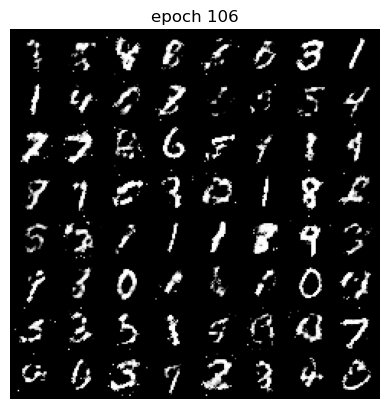

Epoch 106 of 200
Generator loss: 1.32874405, Discriminator loss: 1.11416914


118it [00:15,  7.78it/s]                         


Epoch 107 of 200
Generator loss: 1.29096342, Discriminator loss: 1.13228586


118it [00:15,  7.80it/s]                         


Epoch 108 of 200
Generator loss: 1.28078499, Discriminator loss: 1.13296399


118it [00:15,  7.78it/s]                         


Epoch 109 of 200
Generator loss: 1.26991039, Discriminator loss: 1.13916180


118it [00:17,  6.81it/s]                         


Epoch 110 of 200
Generator loss: 1.25453713, Discriminator loss: 1.14371161


118it [00:27,  4.31it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


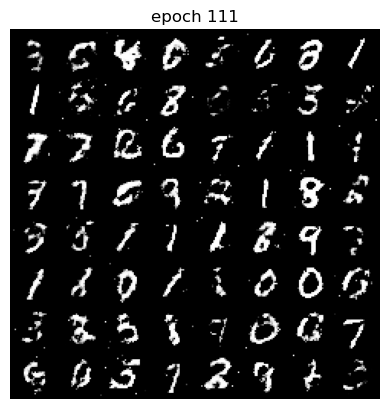

Epoch 111 of 200
Generator loss: 1.26501495, Discriminator loss: 1.14216753


118it [00:27,  4.27it/s]                         


Epoch 112 of 200
Generator loss: 1.25041452, Discriminator loss: 1.15280907


118it [00:27,  4.27it/s]                         


Epoch 113 of 200
Generator loss: 1.22052791, Discriminator loss: 1.16256552


118it [00:27,  4.26it/s]                         


Epoch 114 of 200
Generator loss: 1.20331159, Discriminator loss: 1.17425188


118it [00:27,  4.26it/s]                         


Epoch 115 of 200
Generator loss: 1.20459046, Discriminator loss: 1.16995811


118it [00:27,  4.24it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


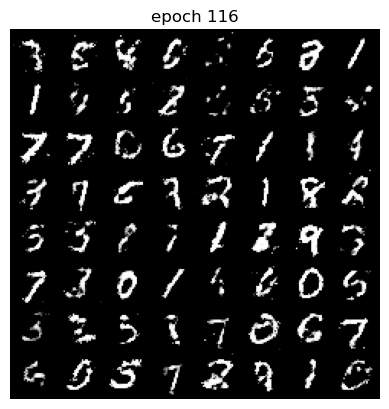

Epoch 116 of 200
Generator loss: 1.20944631, Discriminator loss: 1.16409083


118it [00:27,  4.26it/s]                         


Epoch 117 of 200
Generator loss: 1.20875450, Discriminator loss: 1.17065300


118it [00:27,  4.27it/s]                         


Epoch 118 of 200
Generator loss: 1.24349868, Discriminator loss: 1.15541025


118it [00:27,  4.26it/s]                         


Epoch 119 of 200
Generator loss: 1.24152676, Discriminator loss: 1.15443082


118it [00:27,  4.24it/s]                         


Epoch 120 of 200
Generator loss: 1.23889989, Discriminator loss: 1.15102878


118it [00:28,  4.21it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


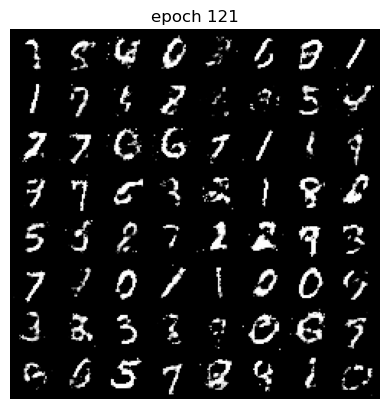

Epoch 121 of 200
Generator loss: 1.26389134, Discriminator loss: 1.14457271


118it [00:28,  4.17it/s]                         


Epoch 122 of 200
Generator loss: 1.25010450, Discriminator loss: 1.15185384


118it [00:27,  4.31it/s]                         


Epoch 123 of 200
Generator loss: 1.21980058, Discriminator loss: 1.16468856


118it [00:27,  4.37it/s]                         


Epoch 124 of 200
Generator loss: 1.21845875, Discriminator loss: 1.16094899


118it [00:26,  4.39it/s]                         


Epoch 125 of 200
Generator loss: 1.19938802, Discriminator loss: 1.17311844


118it [00:26,  4.40it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


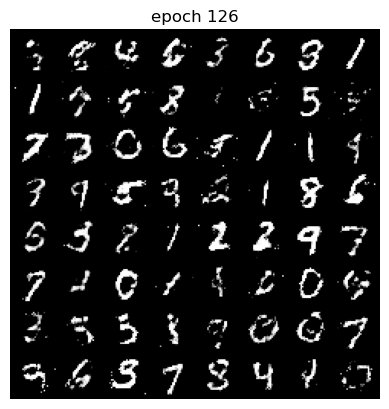

Epoch 126 of 200
Generator loss: 1.17837152, Discriminator loss: 1.18430232


118it [00:27,  4.34it/s]                         


Epoch 127 of 200
Generator loss: 1.23128273, Discriminator loss: 1.15426718


118it [00:27,  4.35it/s]                         


Epoch 128 of 200
Generator loss: 1.20236515, Discriminator loss: 1.17035288


118it [00:27,  4.25it/s]                         


Epoch 129 of 200
Generator loss: 1.19223916, Discriminator loss: 1.17900037


118it [00:28,  4.21it/s]                         


Epoch 130 of 200
Generator loss: 1.18716355, Discriminator loss: 1.17458213


118it [00:26,  4.38it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


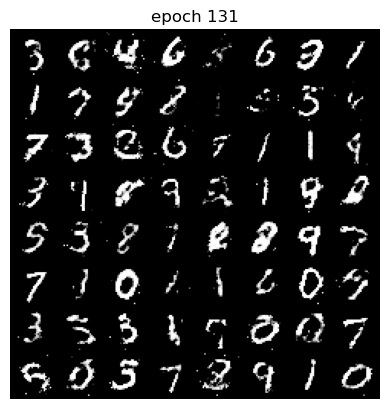

Epoch 131 of 200
Generator loss: 1.18456073, Discriminator loss: 1.18039674


118it [00:27,  4.36it/s]                         


Epoch 132 of 200
Generator loss: 1.17834879, Discriminator loss: 1.17789877


118it [00:26,  4.41it/s]                         


Epoch 133 of 200
Generator loss: 1.16519763, Discriminator loss: 1.19523224


118it [00:26,  4.42it/s]                         


Epoch 134 of 200
Generator loss: 1.18744568, Discriminator loss: 1.17746118


118it [00:26,  4.39it/s]                         


Epoch 135 of 200
Generator loss: 1.22838170, Discriminator loss: 1.15866919


118it [00:26,  4.41it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


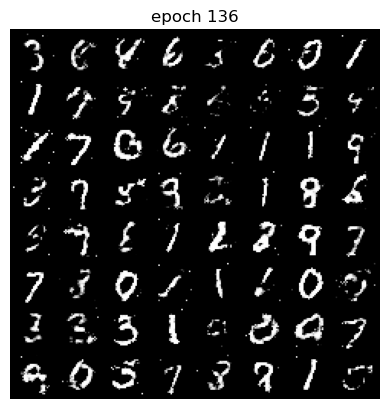

Epoch 136 of 200
Generator loss: 1.16936665, Discriminator loss: 1.18350781


118it [00:26,  4.45it/s]                         


Epoch 137 of 200
Generator loss: 1.19500317, Discriminator loss: 1.17288501


118it [00:26,  4.47it/s]                         


Epoch 138 of 200
Generator loss: 1.16988590, Discriminator loss: 1.18489147


118it [00:26,  4.47it/s]                         


Epoch 139 of 200
Generator loss: 1.18821348, Discriminator loss: 1.17572204


118it [00:26,  4.38it/s]                         


Epoch 140 of 200
Generator loss: 1.14673930, Discriminator loss: 1.19697228


118it [00:26,  4.39it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


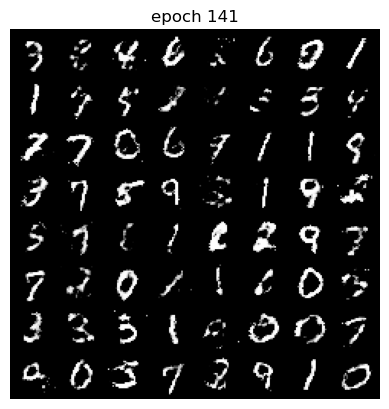

Epoch 141 of 200
Generator loss: 1.16753950, Discriminator loss: 1.17971364


118it [00:26,  4.43it/s]                         


Epoch 142 of 200
Generator loss: 1.13897010, Discriminator loss: 1.20006823


118it [00:26,  4.38it/s]                         


Epoch 143 of 200
Generator loss: 1.13503632, Discriminator loss: 1.20093714


118it [00:26,  4.38it/s]                         


Epoch 144 of 200
Generator loss: 1.16637701, Discriminator loss: 1.18873828


118it [00:26,  4.40it/s]                         


Epoch 145 of 200
Generator loss: 1.15384433, Discriminator loss: 1.19100041


118it [00:26,  4.40it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


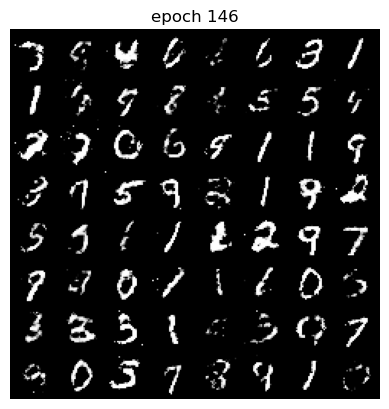

Epoch 146 of 200
Generator loss: 1.15969235, Discriminator loss: 1.18888464


118it [00:26,  4.39it/s]                         


Epoch 147 of 200
Generator loss: 1.17877521, Discriminator loss: 1.18635838


118it [00:26,  4.42it/s]                         


Epoch 148 of 200
Generator loss: 1.12127387, Discriminator loss: 1.20900485


118it [00:27,  4.37it/s]                         


Epoch 149 of 200
Generator loss: 1.15473765, Discriminator loss: 1.19076341


118it [00:26,  4.47it/s]                         


Epoch 150 of 200
Generator loss: 1.13218187, Discriminator loss: 1.19387472


118it [00:26,  4.46it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


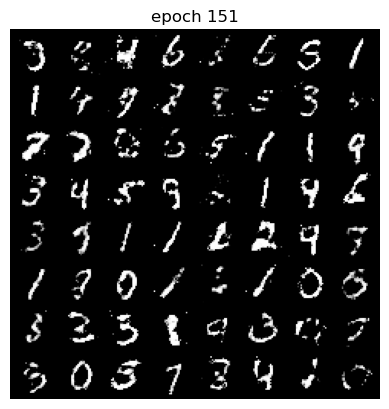

Epoch 151 of 200
Generator loss: 1.10873704, Discriminator loss: 1.20861945


118it [00:26,  4.40it/s]                         


Epoch 152 of 200
Generator loss: 1.12421428, Discriminator loss: 1.20931473


118it [00:27,  4.35it/s]                         


Epoch 153 of 200
Generator loss: 1.13959665, Discriminator loss: 1.19792313


118it [00:27,  4.36it/s]                         


Epoch 154 of 200
Generator loss: 1.16448029, Discriminator loss: 1.18487438


118it [00:27,  4.30it/s]                         


Epoch 155 of 200
Generator loss: 1.15686817, Discriminator loss: 1.19377087


118it [00:27,  4.32it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


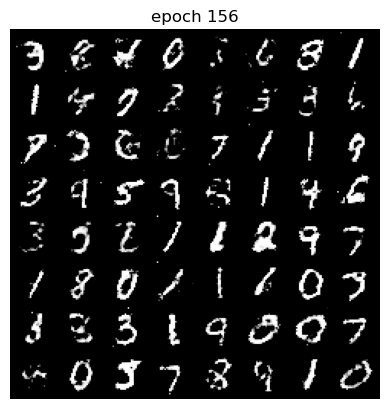

Epoch 156 of 200
Generator loss: 1.16271950, Discriminator loss: 1.18841603


118it [00:26,  4.41it/s]                         


Epoch 157 of 200
Generator loss: 1.16359519, Discriminator loss: 1.19418809


118it [00:26,  4.43it/s]                         


Epoch 158 of 200
Generator loss: 1.14518656, Discriminator loss: 1.19379327


118it [00:26,  4.39it/s]                         


Epoch 159 of 200
Generator loss: 1.14135357, Discriminator loss: 1.19625208


118it [00:26,  4.41it/s]                         


Epoch 160 of 200
Generator loss: 1.15326546, Discriminator loss: 1.19538301


118it [00:27,  4.37it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


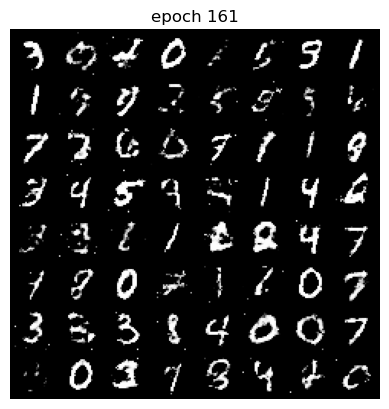

Epoch 161 of 200
Generator loss: 1.11860637, Discriminator loss: 1.20557137


118it [00:26,  4.43it/s]                         


Epoch 162 of 200
Generator loss: 1.13810584, Discriminator loss: 1.20763015


118it [00:26,  4.48it/s]                         


Epoch 163 of 200
Generator loss: 1.11865968, Discriminator loss: 1.20633748


118it [00:26,  4.49it/s]                         


Epoch 164 of 200
Generator loss: 1.13485367, Discriminator loss: 1.19946307


118it [00:27,  4.34it/s]                         


Epoch 165 of 200
Generator loss: 1.13220937, Discriminator loss: 1.19831934


118it [00:27,  4.35it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


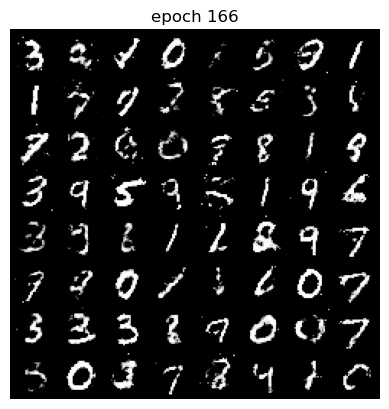

Epoch 166 of 200
Generator loss: 1.13960458, Discriminator loss: 1.19570343


118it [00:26,  4.42it/s]                         


Epoch 167 of 200
Generator loss: 1.13432307, Discriminator loss: 1.20082671


118it [00:27,  4.34it/s]                         


Epoch 168 of 200
Generator loss: 1.11457633, Discriminator loss: 1.20742519


118it [00:28,  4.12it/s]                         


Epoch 169 of 200
Generator loss: 1.13239284, Discriminator loss: 1.20278619


118it [00:27,  4.23it/s]                         


Epoch 170 of 200
Generator loss: 1.12072473, Discriminator loss: 1.21274983


118it [00:26,  4.39it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


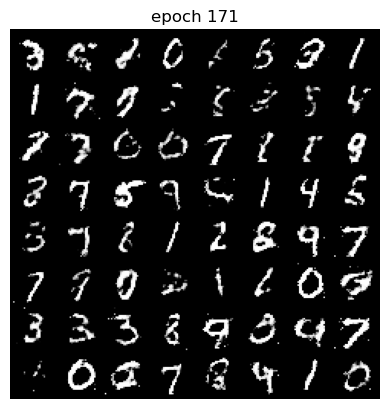

Epoch 171 of 200
Generator loss: 1.11844085, Discriminator loss: 1.20775356


118it [00:27,  4.34it/s]                         


Epoch 172 of 200
Generator loss: 1.14242996, Discriminator loss: 1.19495640


118it [00:23,  5.12it/s]                         


Epoch 173 of 200
Generator loss: 1.10986730, Discriminator loss: 1.20875540


118it [00:15,  7.51it/s]                         


Epoch 174 of 200
Generator loss: 1.11895162, Discriminator loss: 1.22327206


118it [00:15,  7.70it/s]                         


Epoch 175 of 200
Generator loss: 1.10857256, Discriminator loss: 1.21402477


118it [00:15,  7.74it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


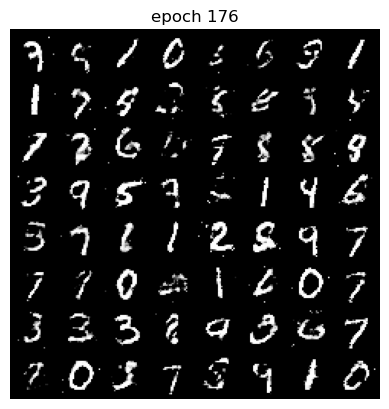

Epoch 176 of 200
Generator loss: 1.10447280, Discriminator loss: 1.21893978


118it [00:16,  7.28it/s]                         


Epoch 177 of 200
Generator loss: 1.11203144, Discriminator loss: 1.21122371


118it [00:16,  7.13it/s]                         


Epoch 178 of 200
Generator loss: 1.11944587, Discriminator loss: 1.21070076


118it [00:15,  7.57it/s]                         


Epoch 179 of 200
Generator loss: 1.09222950, Discriminator loss: 1.21854868


118it [00:15,  7.79it/s]                         


Epoch 180 of 200
Generator loss: 1.11917060, Discriminator loss: 1.20655348


118it [00:15,  7.82it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


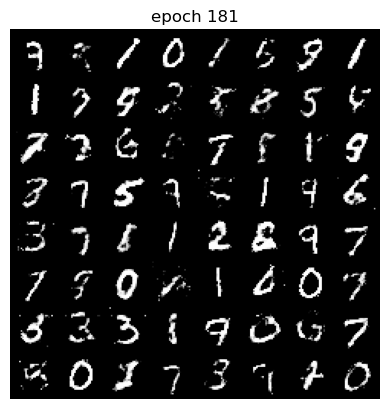

Epoch 181 of 200
Generator loss: 1.09450002, Discriminator loss: 1.21881664


118it [00:15,  7.64it/s]                         


Epoch 182 of 200
Generator loss: 1.07810622, Discriminator loss: 1.23050477


118it [00:15,  7.76it/s]                         


Epoch 183 of 200
Generator loss: 1.08444082, Discriminator loss: 1.22571359


118it [00:15,  7.77it/s]                         


Epoch 184 of 200
Generator loss: 1.08292510, Discriminator loss: 1.22972265


118it [00:15,  7.81it/s]                         


Epoch 185 of 200
Generator loss: 1.07989745, Discriminator loss: 1.22797142


118it [00:15,  7.79it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


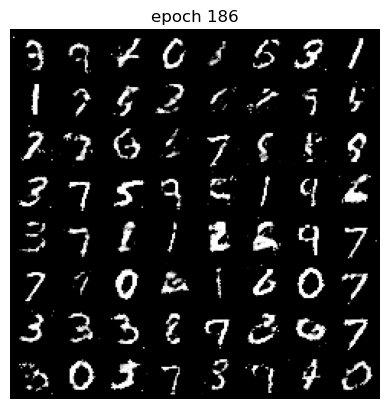

Epoch 186 of 200
Generator loss: 1.08206816, Discriminator loss: 1.22055958


118it [00:15,  7.82it/s]                         


Epoch 187 of 200
Generator loss: 1.08361005, Discriminator loss: 1.22394347


118it [00:15,  7.78it/s]                         


Epoch 188 of 200
Generator loss: 1.08901881, Discriminator loss: 1.21817263


118it [00:15,  7.77it/s]                         


Epoch 189 of 200
Generator loss: 1.09898515, Discriminator loss: 1.21716032


118it [00:15,  7.83it/s]                         


Epoch 190 of 200
Generator loss: 1.09925629, Discriminator loss: 1.21537451


118it [00:15,  7.83it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


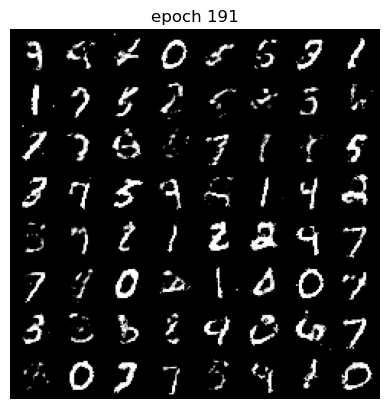

Epoch 191 of 200
Generator loss: 1.09725326, Discriminator loss: 1.21510043


118it [00:15,  7.78it/s]                         


Epoch 192 of 200
Generator loss: 1.09804948, Discriminator loss: 1.22377975


118it [00:15,  7.81it/s]                         


Epoch 193 of 200
Generator loss: 1.07716106, Discriminator loss: 1.23186292


118it [00:21,  5.49it/s]                         


Epoch 194 of 200
Generator loss: 1.07180468, Discriminator loss: 1.22988774


118it [00:27,  4.25it/s]                         


Epoch 195 of 200
Generator loss: 1.08427373, Discriminator loss: 1.22931717


118it [00:27,  4.26it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


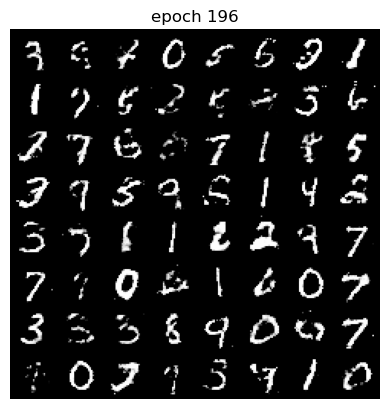

Epoch 196 of 200
Generator loss: 1.06561873, Discriminator loss: 1.23013639


118it [00:27,  4.24it/s]                         


Epoch 197 of 200
Generator loss: 1.07205926, Discriminator loss: 1.23659186


118it [00:27,  4.23it/s]                         


Epoch 198 of 200
Generator loss: 1.08131667, Discriminator loss: 1.22572500


118it [00:27,  4.22it/s]                         


Epoch 199 of 200
Generator loss: 1.06880419, Discriminator loss: 1.22874995


118it [00:27,  4.25it/s]                         

Epoch 200 of 200
Generator loss: 1.08517340, Discriminator loss: 1.22809149


In [14]:
torch.manual_seed(7777)
def generator_loss(output):
    return criterion(output, label_real(output.size(0)))
#     return torch.log(label_real(output.size(0)) - output).mean() # For qeustion 1.b

def discriminator_loss(output_real, output_fake):
    real_loss = criterion(output_real, label_real(output_real.size(0)))
    fake_loss = criterion(output_fake, label_fake(output_fake.size(0)))
    total_loss = real_loss + fake_loss
    return total_loss

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        # Train Discriminator
        real_images, _ = data
        b_size = real_images.size(0)
        real_images = real_images.to(device)
        
        for _ in range (k):
            noise1 = create_noise(b_size, nz)
            fake_images = generator(noise1)
        
            # Update discriminator
            optim_d.zero_grad()
            output_real = discriminator(real_images)
            output_fake = discriminator(fake_images)
            loss_d1 = discriminator_loss(output_real, output_fake)
            loss_d1.backward()
            optim_d.step()
            
        loss_d += loss_d1.item()

        # Train Generator
        for _ in range (k):
            noise2 = create_noise(b_size, nz)
            fake_images = generator(noise2)
        
            # Update generator
            optim_g.zero_grad()
            output = discriminator(fake_images)
            loss_g1 = generator_loss(output)
            loss_g1.backward()
            optim_g.step()

        # Record losses
        loss_g += loss_g1.item()
        ######################################
         # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 1:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [16]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [17]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

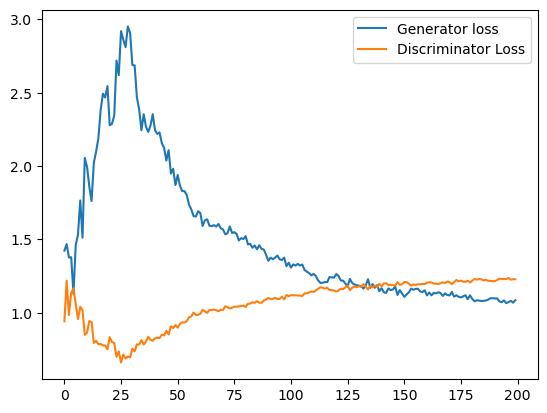

In [18]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')